In [10]:
    %%capture
    !pip install ipython-autotime

    %load_ext autotime

time: 311 µs (started: 2021-03-07 18:21:04 +00:00)


In [2]:
import nltk
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
from bs4 import BeautifulSoup

%matplotlib inline


time: 1.81 s (started: 2021-03-07 17:46:34 +00:00)


# words

In [3]:
!gdown https://drive.google.com/uc?id=1YOjtv8iyXOPISHmLyAabhl1IibnLcCx_

Downloading...
From: https://drive.google.com/uc?id=1YOjtv8iyXOPISHmLyAabhl1IibnLcCx_
To: /content/stemming-assignment.txt
100% 190k/190k [00:00<00:00, 27.4MB/s]
time: 926 ms (started: 2021-03-07 17:46:35 +00:00)


In [4]:
words = open('stemming-assignment.txt').read().split('\n')
len(words)

23532

time: 9.31 ms (started: 2021-03-07 17:46:36 +00:00)


In [5]:
def chunks(lst, n):
  """Yield successive n-sized chunks from lst."""
  for i in range(0, len(lst), n):
    yield lst[i:i+n]

def counter():
  i = 0
  while True:
    i += 1
    yield i


class YASStemmer:
  def __init__(self, words):
    self.words = words
    self.index = {i:self.words[i] for i in range(len(self.words))}
    self.n_words = len(self.words)
    
  
  def D1(self, a, b):
    sm, lr = (a, b) if len(a) < len(b) else (b, a)
    s, l = len(sm), len(lr)
    st = sum([0 if a[i]==b[i] else 1/(2**i) for i in range(s)])
    st += sum([1/(2**i) for i in range(s, l)])
    return st

  def D2(self, a, b):
    sm, lr = (a, b) if len(a) < len(b) else (b, a)
    if len(a) == 0 or len(b) == 0:
      return 100
    elif a[0] != b[0]:
      return 100
    m = 0
    D = 0
    for i in range(len(sm)):
      if a[i] != b[i]:
        m = i
        break
      if i == len(sm) - 1:
        m = i + 1
    for i in range(m, len(lr)):
      D += 1/(2**(i-m))
    D = D / m

    return D
    
  def D3(self, a, b):
    sm, lr = (a, b) if len(a) < len(b) else (b, a)
    if not len(a) or not len(b):
      return 100
    elif a[0] != b[0]:
      return 100
    m = 0
    n = len(lr) - 1
    D = 0
    for i in range(len(sm)):
      if a[i] != b[i]:
        m = i
        break
      if i == len(sm) - 1:
        m = i + 1
    for i in range(m, len(lr)):
      D += 1/(2**(i-m))
    D = (D * (n -m + 1))  / m
    return D

  def D4(self, a, b):
    sm = min([a, b], key= lambda x: len(x))
    lr = max([a, b], key=lambda x: len(x))
    if not len(a) or not len(b):
      return 100
    elif a[0] != b[0]:
      return 100
    m = 0
    n = len(lr) - 1
    D = 0
    for i in range(len(sm)):
      if not len(a) or not len(b):
        break
      elif a[i] != b[i]:
        m = i
        break
    if i == len(sm) -  1:
      m = i + 1
    for i in range(m, len(lr)):
      D += 1/(2**(i-m))
    D = (D * (n -m + 1))  / (n+1)
    return D

  def DistanceMatrix(self, fn, n=2, load=False, path=None):
    if load:
      from google.colab import drive
      drive.mount('/gdrive')
      self.distMatrix = [np.load(path+file) for file in os.listdir(path)]
    else:
      lexGen = chunks(self.words, len(self.words)//n)
      self.distMatrix = []
      while True:
        try:
          x = next(lexGen)
          self.distMatrix.append(np.array([[fn(a, b) for a in x] for b in x]))
        except StopIteration:
          break
      return self.distMatrix
  
  def saveMatrices(self, path):
    from google.colab import drive
    drive.mount('/gdrive')
    c = counter()
    for dmat in self.distMatrix:
      np.save(f'{path}/D{next(c)}.npy', dmat)

  def performClustering(self, algo, linkage, distanceThreshold):
    self.clusters = []
    for dmat in self.distMatrix:
      self.clusters.append(algo(affinity='precomputed', 
          n_clusters=None, distance_threshold=distanceThreshold, linkage=linkage).fit(dmat))
    self.n_clusters = sum([cluster.n_clusters_ for cluster in self.clusters])
    return self.n_clusters
  
  def findCenter(self):
    mapr = {i:[] for i in range(self.n_clusters)}
    for i in range(len(self.clusters)):
      for j in range(len(self.clusters[i].labels_)):
        mapr[self.clusters[i].labels_[j] + self.clusters[0].n_clusters_ * i].append(j + 
                self.n_words//len(self.clusters) * i)
    self.clusterWords = {cl:list(map(lambda x: self.index[x], mapr[cl])) for cl in mapr}
  
  def rootword(self):
    rootmap = dict()
    for cluster in self.clusterWords:
      x = min(self.clusterWords[cluster], key=lambda x: len(x))
      for word in self.clusterWords[cluster]:
        rootmap[word] = x
        
    return rootmap
    


    



time: 271 ms (started: 2021-03-07 17:46:36 +00:00)


In [6]:
yas = YASStemmer(words)

time: 8.74 ms (started: 2021-03-07 17:46:37 +00:00)


Let's first check if our distance functions are working or not

In [7]:
for fn in [yas.D1, yas.D2, yas.D3, yas.D4]:
  print(f'fn {fn} {fn("astronomer","astronomically")}')
print('-'*100)
for fn in [yas.D1, yas.D2, yas.D3, yas.D4]:
  print(f'fn {fn} {fn("astronomer", "astonish")}')


fn <bound method YASStemmer.D1 of <__main__.YASStemmer object at 0x7f36a2977b50>> 0.0076904296875
fn <bound method YASStemmer.D2 of <__main__.YASStemmer object at 0x7f36a2977b50>> 0.24609375
fn <bound method YASStemmer.D3 of <__main__.YASStemmer object at 0x7f36a2977b50>> 1.4765625
fn <bound method YASStemmer.D4 of <__main__.YASStemmer object at 0x7f36a2977b50>> 0.84375
----------------------------------------------------------------------------------------------------
fn <bound method YASStemmer.D1 of <__main__.YASStemmer object at 0x7f36a2977b50>> 0.248046875
fn <bound method YASStemmer.D2 of <__main__.YASStemmer object at 0x7f36a2977b50>> 0.6614583333333334
fn <bound method YASStemmer.D3 of <__main__.YASStemmer object at 0x7f36a2977b50>> 4.630208333333333
fn <bound method YASStemmer.D4 of <__main__.YASStemmer object at 0x7f36a2977b50>> 1.3890625
time: 4 ms (started: 2021-03-07 16:00:57 +00:00)


Here are the values from paper

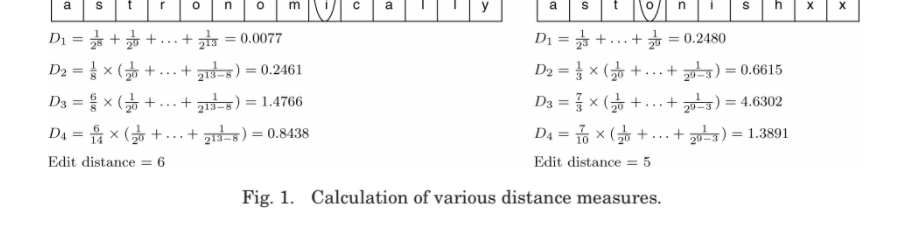

# D1


In [11]:
yas.DistanceMatrix(yas.D1, 2, True, '/gdrive/MyDrive/matrix/D1/')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
time: 19.4 s (started: 2021-03-07 16:06:02 +00:00)


In [77]:
# yas.saveMatrices('/gdrive/MyDrive/matrix/D1')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
time: 16.4 s (started: 2021-03-07 13:51:36 +00:00)


Text(0, 0.5, 'Number of clusters')

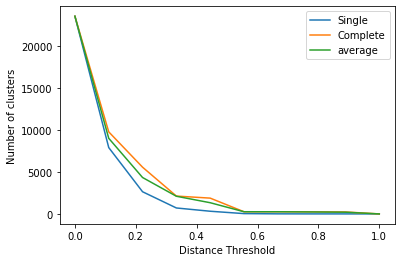

time: 3min 31s (started: 2021-03-07 13:51:56 +00:00)


In [78]:
x = np.linspace(0,1,10)
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'single', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'complete', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'average', i) for i in x], '-')
plt.legend(['Single', 'Complete', 'average'])
plt.xlabel('Distance Threshold')
plt.ylabel('Number of clusters')

In [79]:
yas.performClustering(AgglomerativeClustering, 'average', 0.1)

10446

time: 10.1 s (started: 2021-03-07 13:55:32 +00:00)


In [80]:
yas.findCenter()

time: 436 ms (started: 2021-03-07 13:55:42 +00:00)


In [81]:
list(yas.clusterWords[4])

['chare', 'chares', 'chary', 'charybdis']

time: 4.1 ms (started: 2021-03-07 13:55:43 +00:00)


# D2

In [ ]:
yas.DistanceMatrix(yas.D2, 2)

In [83]:
yas.saveMatrices('/gdrive/MyDrive/matrix/D2')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
time: 16 s (started: 2021-03-07 14:00:29 +00:00)


Text(0.5, 1.0, 'CLustering using D3 distance metric')

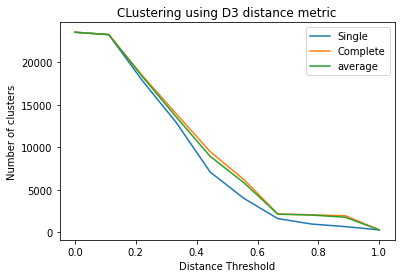

time: 2min 34s (started: 2021-03-07 14:01:17 +00:00)


In [84]:
x = np.linspace(0,1,10)
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'single', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'complete', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'average', i) for i in x], '-')
plt.legend(['Single', 'Complete', 'average'])
plt.xlabel('Distance Threshold')
plt.ylabel('Number of clusters')
plt.title('CLustering using D2 distance metric')

In [85]:
yas.performClustering(AgglomerativeClustering, 'average', 0.4)

10281

time: 6.16 s (started: 2021-03-07 14:07:25 +00:00)


In [86]:
yas.findCenter()

time: 209 ms (started: 2021-03-07 14:07:31 +00:00)


In [87]:
list(yas.clusterWords[500])

['catch', 'catcher', 'catches', 'catching']

time: 3.51 ms (started: 2021-03-07 14:07:31 +00:00)


# D3

In [ ]:
yas.DistanceMatrix(yas.D3, 2)

In [89]:
yas.saveMatrices('/gdrive/MyDrive/matrix/D3')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
time: 17 s (started: 2021-03-07 14:13:37 +00:00)


Text(0.5, 1.0, 'CLustering using D3 distance metric')

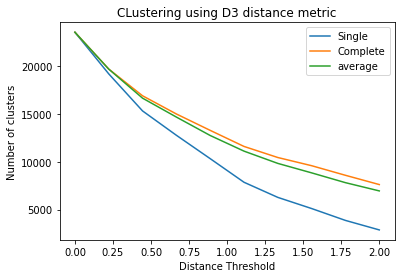

time: 2min 42s (started: 2021-03-07 14:14:09 +00:00)


In [90]:
x = np.linspace(0,2,10)
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'single', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'complete', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'average', i) for i in x], '-')
plt.legend(['Single', 'Complete', 'average'])
plt.xlabel('Distance Threshold')
plt.ylabel('Number of clusters')
plt.title('CLustering using D3 distance metric')

In [91]:
yas.performClustering(AgglomerativeClustering, 'average', 1.2)

10901

time: 6.01 s (started: 2021-03-07 14:17:07 +00:00)


In [92]:
yas.findCenter()

time: 51.5 ms (started: 2021-03-07 14:17:13 +00:00)


In [97]:
list(yas.clusterWords[175])

['float', 'floated', 'floating']

time: 9.71 ms (started: 2021-03-07 14:18:08 +00:00)


# D4

In [7]:
yas.DistanceMatrix(yas.D4, 2, True, '/gdrive/MyDrive/matrix/D4/')

Mounted at /gdrive
time: 43.3 s (started: 2021-03-07 17:46:42 +00:00)


In [8]:
# yas.saveMatrices('/gdrive/MyDrive/matrix/D4')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
time: 17.7 s (started: 2021-03-07 14:41:04 +00:00)


Text(0.5, 1.0, 'CLustering using D4 distance metric')

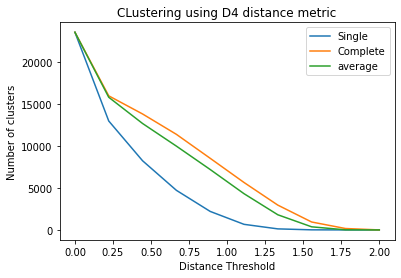

time: 2min 26s (started: 2021-03-07 14:42:10 +00:00)


In [9]:
x = np.linspace(0,2,10)
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'single', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'complete', i) for i in x], '-')
plt.plot(x, [yas.performClustering(AgglomerativeClustering, 'average', i) for i in x], '-')
plt.legend(['Single', 'Complete', 'average'])
plt.xlabel('Distance Threshold')
plt.ylabel('Number of clusters')
plt.title('CLustering using D4 distance metric')

In [8]:
yas.performClustering(AgglomerativeClustering, 'complete', 0.5)

13689

time: 6.78 s (started: 2021-03-07 17:47:36 +00:00)


In [9]:
yas.findCenter()

time: 66.6 ms (started: 2021-03-07 17:47:42 +00:00)


In [10]:
yasstem = yas.rootword()

time: 25 ms (started: 2021-03-07 17:47:42 +00:00)


In [11]:
yas.clusterWords[124]

['distress', 'distressed', 'distresses', 'distressful']

time: 4.91 ms (started: 2021-03-07 17:47:43 +00:00)


# Levenshtein edit-distance

In [27]:

def _edit_dist_init(len1, len2):
    lev = []
    for i in range(len1):
        lev.append([0] * len2)  # initialize 2D array to zero
    for i in range(len1):
        lev[i][0] = i  # column 0: 0,1,2,3,4,...
    for j in range(len2):
        lev[0][j] = j  # row 0: 0,1,2,3,4,...
    return lev

def _edit_dist_step(lev, i, j, s1, s2, substitution_cost=1, transpositions=False):
    c1 = s1[i - 1]
    c2 = s2[j - 1]

    # skipping a character in s1
    a = lev[i - 1][j] + 1
    # skipping a character in s2
    b = lev[i][j - 1] + 1
    # substitution
    c = lev[i - 1][j - 1] + (substitution_cost if c1 != c2 else 0)

    # transposition
    d = c + 1  # never picked by default
    if transpositions and i > 1 and j > 1:
        if s1[i - 2] == c2 and s2[j - 2] == c1:
            d = lev[i - 2][j - 2] + 1

    # pick the cheapest
    lev[i][j] = min(a, b, c, d)
  
def edit_distance(s1, s2, substitution_cost=1, transpositions=False):
    """
    Calculate the Levenshtein edit-distance between two strings.
    """
    # set up a 2-D array
    len1 = len(s1)
    len2 = len(s2)
    lev = _edit_dist_init(len1 + 1, len2 + 1)

    # iterate over the array
    for i in range(len1):
        for j in range(len2):
            _edit_dist_step(
                lev,
                i + 1,
                j + 1,
                s1,
                s2,
                substitution_cost=substitution_cost,
                transpositions=transpositions,
            )
    return lev[len1][len2]

time: 76.1 ms (started: 2021-03-07 14:50:05 +00:00)


In [ ]:
yas.DistanceMatrix(edit_distance, 2)

# Retrieval Using pyterrier

In [12]:
%%capture
!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git #egg=python-terrier

time: 29 s (started: 2021-03-07 17:48:02 +00:00)


Let's first download configure the dataset.

In [13]:
%%capture
!gdown https://drive.google.com/uc?id=1JuawXQmYVkjpfL3H0blqjDrqw8V1lHrC
!unrar e /content/FIRE_Dataset_EN_2010.rar
!gunzip /content/en.qrels.76-125.2010.txt.gz
!tar -xzvf English-Data.tgz

time: 20 s (started: 2021-03-07 17:48:31 +00:00)


In [14]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

time: 164 ms (started: 2021-03-07 17:48:51 +00:00)


In [15]:
def remove_stopwords(words):
  """
  Removes the stop words from a list of words
  """
  engstopwords = stopwords.words('english')
  nostopwords = filter(lambda x: x not in engstopwords and len(x) != 1, words)
  return nostopwords


time: 3.51 ms (started: 2021-03-07 17:48:52 +00:00)


In [16]:
def tokenize_words(text):
  """
  The function tokenizes the words removes special characters, numbers and returns list of lowercase tokens
  """
  text = text.lower()
  tokens = nltk.regexp_tokenize(text, '[a-zA-Z]+', gaps=False)
  
  return tokens

time: 4.54 ms (started: 2021-03-07 17:48:52 +00:00)


In [17]:
curry = lambda x: " ".join(remove_stopwords(tokenize_words(x)))

time: 2.02 ms (started: 2021-03-07 17:48:52 +00:00)


In [20]:

def porter_doc_iter():
  for file in glob.iglob("TELEGRAPH_UTF8/**/*.utf8", recursive=True):
    yield {'doc': file.split('/')[-1], 'text': curry(open(file).read())}

time: 2 ms (started: 2021-03-07 17:49:32 +00:00)


In [21]:
yascurry = lambda x: " ".join([yasstem[word] if word in words else word for word in tokenize_words(x)])


time: 2.84 ms (started: 2021-03-07 17:49:34 +00:00)


In [22]:
def yas_doc_iter():
  for file in glob.iglob("TELEGRAPH_UTF8/**/*.utf8", recursive=True):
    yield {'doc': file.split('/')[-1], 'text': yascurry(open(file).read())}

time: 4.22 ms (started: 2021-03-07 17:49:36 +00:00)


In [23]:
import pyterrier as pt
if not pt.started():
    pt.init()



time: 6.34 ms (started: 2021-03-07 17:49:40 +00:00)


In [24]:
!rm -rf ./iter_index
iter_indexer = pt.IterDictIndexer("./iter_index")

doc_iter = porter_doc_iter()
porterindex = iter_indexer.index(doc_iter)

time: 4min 4s (started: 2021-03-07 17:49:54 +00:00)


In [2]:
! rm -rf ./yass_iter_indexer
yassindex = pt.IterDictIndexer("./yass_iter_indexer")
yassindex.setProperty("termpipelines","")

yas_iter = yas_doc_iter()
yasindex = yassindex.index(yas_iter)

time: 6min 2s (started: 2021-03-07 17:55:51 +00:00)


In [1]:
tdidf_porterstemmer = pt.BatchRetrieve(porterindex, controls = {"wmodel":"TF_IDF"}, properties = {"termpipelines":"PorterStemmer"})

time: 45.5 ms (started: 2021-03-07 18:02:54 +00:00)


In [4]:
tdidf_yass = pt.BatchRetrieve(yasindex, controls = {"wmodel":"TF_IDF"}, properties = {"termpipelines":"Stopwords"})

time: 53.7 ms (started: 2021-03-07 17:49:54 +00:00)


In [24]:
qstr = open("/content/en.topics.76-125.2010.txt").read()

time: 5.45 ms (started: 2021-03-07 16:32:55 +00:00)


In [26]:

ls = qstr.split('</top>')[:-1]
topics = pd.concat([pd.DataFrame([[BeautifulSoup(query, 'lxml').find('num').text, 
        curry(BeautifulSoup(query, 'lxml').find('desc').text.replace('\n', " "))]], 
        columns=['qid', 'query']) for query in ls], ignore_index=True)



time: 155 ms (started: 2021-03-07 16:35:38 +00:00)


In [27]:
topics.head()

,qid,query
0,76,reasons behind protests meena leaders inclusio...
1,77,attacks hezbollah guerrillas indian israeli fo...
2,78,conflict ashok singhal president vishwa hindu ...
3,79,plans build road china mount everest
4,80,initiation legal proceedings advani involvemen...


time: 35.4 ms (started: 2021-03-07 16:35:43 +00:00)


In [28]:
estr = open("/content/en.qrels.76-125.2010.txt").read().split('\n')
elist = [est for est in estr if est.endswith('1')]
elist = [e.split(' ') for e in elist ]
qrels = pd.concat([pd.DataFrame([[e[0], e[2], e[3]]], 
        columns=['qid', 'docno','label']) for e in elist], ignore_index=True)

qrels.head()

,qid,docno,label
0,76,1070530_nation_story_7849973.utf8,1
1,76,1070602_nation_story_7865940.utf8,1
2,76,1070603_nation_story_7869357.utf8,1
3,76,1070611_nation_story_7906812.utf8,1
4,77,1050110_foreign_story_4234881.utf8,1


time: 399 ms (started: 2021-03-07 16:36:00 +00:00)


In [5]:
experiment = pt.Experiment(
    [tdidf_yass, tdidf_porterstemmer],
    topics, 
    qrels, 
    eval_metrics = ["map"],
    names =["yass-stemmer","porter-stemmer"])

time: 2min 34s (started: 2021-03-07 18:21:51 +00:00)


In [11]:
experiment

,name,map
0,yass-stemmer,0.46539
1,porter-stemmer,0.38727


time: 16.6 ms (started: 2021-03-07 18:21:16 +00:00)
